<a href="https://colab.research.google.com/github/annabelle1217/computer-vision-mediapipe/blob/main/colab/hand_gesture_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand Gesture Decoder

## Table of Content
0. [Import Dependencies](#install)
1. [Hands Detection using MediaPipe](#detection) 
2. [Feature Extraction](#feature-extraction) 
    1. [Write Columns Head in CSV File](#csv-header)
    2. [Extract Features of Assigned Class](#save-coordinates)
3. [Train Neural Network Using Tensorflow](#model)
    1. [Load and Preprocess Input Data](#load-input)
    2. [Train A MLP Model](#training)
    3. [Evaluate and Serialize Model](#evaluate)
4. [Real-time Detections with Model](#real-time-detection)

## 0. Install and Import Dependencies <a id="install"></a>

In [1]:
!pip install mediapipe opencv-python tensorflow scikit-learn h5py pandas numpy matplotlib

In [2]:
from mediapipe import solutions as mp
import cv2
import os
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from PIL import Image
import base64
import html
import io

## 1. Hands Detection using MediaPipe <a id="detection"></a>

In [3]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

# Helper functions for video frame extraction and drawing landmarks
def js_to_image(js_reply):
  """
  Params:js_reply: JavaScript object containing image from webcam
  Returns:img: OpenCV BGR image
  """
  # Decode base64 image
  image_bytes = base64.b64decode(js_reply.split(',')[1])
  # Convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # Decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def drawing_array_to_bytes(drawing_array):
  """
  input: drawing_array: landmarks from holistic result
  output: drawing_bytes: string, encoded from drawing_array
  """
  drawing_PIL = Image.fromarray(drawing_array, 'RGB')
  iobuf = io.BytesIO()
  drawing_PIL.save(iobuf, format='png')
  drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
  return drawing_bytes
  
def video_frame(label, bytes):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bytes))
  return data

In [4]:
# Start streaming video from webcam
video_stream()
# Label for video
label_html = 'Hands Detection'

drawing_lm = ''

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

  while True:
      js_reply = video_frame(label_html, drawing_lm)
      
      if not js_reply:
          break

      # Convert JS response to OpenCV Image
      image = js_to_image(js_reply["img"])

      # Recolor feed
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
      # Make detections
      results = hands.process(image)

      if results.multi_hand_landmarks:
          for hand_landmark in results.multi_hand_landmarks:
              
              # Draw hand landmarks
              mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
  
      # Convert overlay of landmarks into bytes
      lm_bytes = drawing_array_to_bytes(image)
      
      # Update landmarks so next frame gets new overlay
      drawing_lm = lm_bytes

<IPython.core.display.Javascript object>

## 2. Feature Extraction <a id="feature-extraction"></a>

### Write Columns Head in CSV File <a id="csv-header"></a>

In [5]:
mp.hands.Hands??

In [6]:
num_coords = len(results.multi_hand_landmarks[0].landmark) 
num_coords

21

In [7]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val),
                  'z{}'.format(val), 'v{}'.format(val)]

In [8]:
if not os.path.exists("data"):
    os.mkdir("data")

with open("data/hand_gesture_coords.csv", mode="w", newline="" ) as f:
    csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

### Extract Features of Assigned Class <a id="save-coordinates"></a>

In [13]:
class_name = "rock"

In [14]:
# Start streaming video from webcam
video_stream()
# Label for video
label_html = "Feature Extraction - Change 'class_name' and Repeat This Step"

drawing_lm = ''

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

  while True:
      js_reply = video_frame(label_html, drawing_lm)
      
      if not js_reply:
          break

      # Convert JS response to OpenCV Image
      image = js_to_image(js_reply["img"])

      # Recolor feed
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Make detections
      results = hands.process(image)

      if results.multi_hand_landmarks:
          for hand_landmark in results.multi_hand_landmarks:
              
              # Draw hand landmarks
              mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
              
              hand = hand_landmark.landmark
              row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                        for landmark in hand]).flatten())
              
              # Append class name
              row.insert(0, class_name)
          
              # Export to CVS
              with open("data/hand_gesture_coords.csv", mode="a", newline="" ) as f:
                  csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
                  csv_writer.writerow(row)  

      # Convert overlay of landmarks into bytes
      lm_bytes = drawing_array_to_bytes(image)
      
      # Update landmarks so next frame gets new overlay
      drawing_lm = lm_bytes

<IPython.core.display.Javascript object>

## 3. Train Nueral Network Using Tensorflow <a id="model"></a>

### Load and Preprocess Input Data <a id="load-input"></a>

In [15]:
df = pd.read_csv("data/hand_gesture_coords.csv")
df

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,z3,v3,x4,y4,z4,v4,x5,y5,z5,v5,x6,y6,z6,v6,x7,y7,z7,v7,x8,y8,z8,v8,x9,y9,z9,v9,x10,y10,z10,...,x12,y12,z12,v12,x13,y13,z13,v13,x14,y14,z14,v14,x15,y15,z15,v15,x16,y16,z16,v16,x17,y17,z17,v17,x18,y18,z18,v18,x19,y19,z19,v19,x20,y20,z20,v20,x21,y21,z21,v21
0,seven,0.381095,0.959592,-0.000055,0.0,0.453655,0.927017,-0.035595,0.0,0.502067,0.813657,-0.070095,0.0,0.536527,0.735630,-0.110478,0.0,0.577345,0.686261,-0.153346,0.0,0.423417,0.691384,-0.056790,0.0,0.411155,0.573390,-0.123737,0.0,0.400801,0.504623,-0.165834,0.0,0.389411,0.436162,-0.191751,0.0,0.365846,0.693686,-0.075087,...,0.423213,0.806798,-0.184479,0.0,0.423988,0.856688,-0.163889,0.0,0.320773,0.728378,-0.102282,0.0,0.363367,0.764743,-0.189708,0.0,0.381147,0.837724,-0.189243,0.0,0.385674,0.873883,-0.172087,0.0,0.285029,0.772749,-0.131537,0.0,0.325094,0.793197,-0.178624,0.0,0.348495,0.844690,-0.166058,0.0,0.355762,0.872591,-0.143222,0.0
1,seven,0.346444,0.680977,-0.000110,0.0,0.404135,0.636734,-0.059735,0.0,0.450219,0.523777,-0.080888,0.0,0.472553,0.431530,-0.102329,0.0,0.498842,0.365448,-0.127251,0.0,0.376584,0.419042,-0.044699,0.0,0.353563,0.311273,-0.080034,0.0,0.335801,0.248733,-0.102978,0.0,0.320799,0.189945,-0.126376,0.0,0.331788,0.439240,-0.044140,...,0.336027,0.478509,-0.150888,0.0,0.349385,0.544441,-0.146258,0.0,0.289477,0.468081,-0.052155,0.0,0.282392,0.447423,-0.139920,0.0,0.302065,0.530496,-0.154119,0.0,0.320436,0.591385,-0.142284,0.0,0.247781,0.504899,-0.063578,0.0,0.234622,0.451804,-0.122062,0.0,0.246980,0.482009,-0.133544,0.0,0.259186,0.510028,-0.131368,0.0
2,seven,0.349631,0.696149,-0.000077,0.0,0.406812,0.650245,-0.061891,0.0,0.451105,0.534083,-0.081960,0.0,0.472002,0.442156,-0.103648,0.0,0.497490,0.379146,-0.127801,0.0,0.379880,0.426494,-0.044180,0.0,0.356742,0.322426,-0.085579,0.0,0.339576,0.260714,-0.112284,0.0,0.323447,0.201241,-0.138222,0.0,0.333312,0.446271,-0.042902,...,0.339175,0.490548,-0.164362,0.0,0.352944,0.560511,-0.159845,0.0,0.290809,0.474770,-0.050810,0.0,0.284694,0.460561,-0.143341,0.0,0.305306,0.544150,-0.159093,0.0,0.325429,0.607099,-0.144169,0.0,0.249512,0.512076,-0.063622,0.0,0.236499,0.464761,-0.126285,0.0,0.251783,0.501692,-0.138362,0.0,0.267763,0.536081,-0.131561,0.0
3,seven,0.791341,0.780240,-0.000132,0.0,0.857105,0.736451,0.015470,0.0,0.902207,0.644100,-0.000489,0.0,0.928899,0.576769,-0.035550,0.0,0.965777,0.532362,-0.072068,0.0,0.844477,0.520826,0.021258,0.0,0.856163,0.423368,-0.023007,0.0,0.861897,0.358353,-0.056253,0.0,0.865417,0.301145,-0.076139,0.0,0.803649,0.517528,-0.023999,...,0.894022,0.604203,-0.099591,0.0,0.882764,0.658811,-0.086448,0.0,0.772933,0.537273,-0.075588,0.0,0.848723,0.566208,-0.130628,0.0,0.855764,0.647738,-0.117321,0.0,0.841282,0.691537,-0.099520,0.0,0.749648,0.570850,-0.128987,0.0,0.813574,0.589857,-0.155043,0.0,0.826950,0.641762,-0.136644,0.0,0.815910,0.674716,-0.121380,0.0
4,seven,0.781107,0.771253,-0.000116,0.0,0.850965,0.736974,0.014977,0.0,0.902625,0.645966,-0.005411,0.0,0.931606,0.575880,-0.041688,0.0,0.968912,0.520779,-0.080201,0.0,0.849825,0.521374,0.014066,0.0,0.858144,0.418168,-0.031506,0.0,0.861749,0.351829,-0.063006,0.0,0.862691,0.292557,-0.086573,0.0,0.809563,0.519408,-0.029179,...,0.885662,0.606786,-0.118823,0.0,0.874080,0.659297,-0.110560,0.0,0.777006,0.535579,-0.078103,0.0,0.847344,0.561145,-0.141251,0.0,0.853673,0.641022,-0.135242,0.0,0.841361,0.679362,-0.121404,0.0,0.750126,0.565425,-0.127607,0.0,0.810155,0.583350,-0.156609,0.0,0.824141,0.639970,-0.147836,0.0,0.815944,0.672692,-0.138041,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,rock,0.481530,0.852982,-0.000128,0.0,0.551606,0.867597,-0.067996,0.0,0.629759,0.800004,-0.090538,0.0,0.679769,0.731791,-0.110611,0.0,0.730112,

In [16]:
# Split into input and output columns
X = df.drop("class", axis=1)
y = df["class"]

# Ensure all data are floating point values
X = X.astype('float32')

# Encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)
np.save("data/hand_geture_classes.npy", le.classes_)

In [17]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Determine the number of input features
n_features = X_train.shape[1]

# Determine the number or classes
n_class = len(np.unique(y_train))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64, 84) (17, 84) (64,) (17,)


### Train A MLP Model <a id="training"></a>

In [18]:
# Define a model with the sequential api
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(n_class, activation='softmax'))

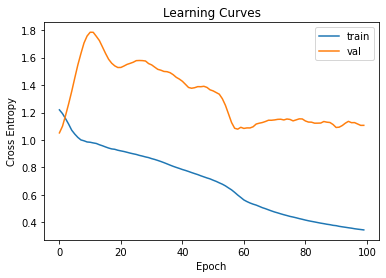

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2)

# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

### Evaluate and Serialize Model <a id="evaluate"></a>

In [20]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# Make a prediction
row = np.random.randn(1, n_features)
yhat = model.predict([row])
print('Predicted: %s (class=%d | %s)' % (yhat, np.argmax(yhat), list(le.inverse_transform([np.argmax(yhat)]))[0]))

Test Accuracy: 0.706
Predicted: [[0.26227075 0.326055   0.41167426]] (class=2 | seven)


In [21]:
if not os.path.exists("generated_model"):
    os.mkdir("generated_model")
    
# Save model to file
model.save("generated_model/hand_gesture_model.h5")

## 4. Real-time Detections with Model <a id="real-time-detection"></a>

In [22]:
# Load the model from file
model_inference = load_model("generated_model/hand_gesture_model.h5")

In [23]:
# Load the class names
le = LabelEncoder()
le.classes_ = np.load("data/hand_geture_classes.npy", allow_pickle=True)

In [25]:
# Start streaming video from webcam
video_stream()
# Label for video
label_html = 'Real Time Detection'

drawing_lm = ''

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

  while True:
      js_reply = video_frame(label_html, drawing_lm)
      
      if not js_reply:
          break

      # Convert JS response to OpenCV Image
      image = js_to_image(js_reply["img"])

      # Recolor feed
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Make detections
      results = hands.process(image)
      
      if results.multi_hand_landmarks:
          for hand_landmark in results.multi_hand_landmarks:
              
              # Draw hand landmarks
              mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
              
              hand = hand_landmark.landmark
              row = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                        for landmark in hand]).flatten()
                    
              # Predict using inference model
              pred = model_inference.predict(row.reshape(1, -1))
              class_name = list(le.inverse_transform([np.argmax(pred)]))[0]
              prob = np.max(pred).round(2)
              print(class_name, prob)
      
              # Display result 
              cv2.rectangle(image, (0,0), (250,60), (245, 117, 16), -1)
              cv2.putText(image, "CLASS", (95,12), cv2.FONT_HERSHEY_SIMPLEX,
                          0.5, (0,0,0), 1, cv2.LINE_AA)
              cv2.putText(image, class_name, (90,40), cv2.FONT_HERSHEY_SIMPLEX,
                          1, (255, 255, 255), 2, cv2.LINE_AA)
              cv2.putText(image, "PROB", (15,12), cv2.FONT_HERSHEY_SIMPLEX,
                          0.5, (0,0,0), 1, cv2.LINE_AA)
              cv2.putText(image, str(prob), (10,40), cv2.FONT_HERSHEY_SIMPLEX,
                          1, (255, 255, 255), 2, cv2.LINE_AA)

      # Convert overlay of landmarks into bytes
      lm_bytes = drawing_array_to_bytes(image)
      
      # Update landmarks so next frame gets new overlay
      drawing_lm = lm_bytes

<IPython.core.display.Javascript object>

ok 0.74
ok 0.73
ok 0.77
ok 0.94
seven 0.66
seven 0.64
seven 0.66
seven 0.61
seven 0.7
seven 0.69
seven 0.54
seven 0.62
seven 0.64
seven 0.63
seven 0.62
rock 0.51
ok 0.47
seven 0.49
rock 0.44
rock 0.44
rock 0.49
rock 0.49
rock 0.49
rock 0.49
rock 0.52
rock 0.49
rock 0.43
seven 0.68
seven 0.55
seven 0.54
seven 0.53
seven 0.54
seven 0.6
seven 0.63
